In [1]:
# In order to force the reload of modules
# %load_ext autoreload
# %autoreload 2

# In order to make the import of local modules
import sys
sys.path.append('../..')

from ml.rl.core import *

import abc
from collections import *
from dataclasses import *
import enum
import gym
import heapq
import numpy as np
import pandas as pd
import random
from tqdm import tqdm, trange
# from tqdm import tnrange, tqdm_notebook
from typing import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
with gym.make("FrozenLake8x8-v0") as env:
    print(env.action_space)
    print(env.observation_space)
    print(env.__dict__)

Discrete(4)
Discrete(64)
{'env': <gym.envs.toy_text.frozen_lake.FrozenLakeEnv object at 0x11fdc68d0>, 'action_space': Discrete(4), 'observation_space': Discrete(64), 'reward_range': (0, 1), 'metadata': {'render.modes': ['human', 'ansi']}, 'spec': EnvSpec(FrozenLake8x8-v0), '_max_episode_seconds': None, '_max_episode_steps': 200, '_elapsed_steps': 0, '_episode_started_at': None}


4958/5000 (99.16%) - 416.83 it/s


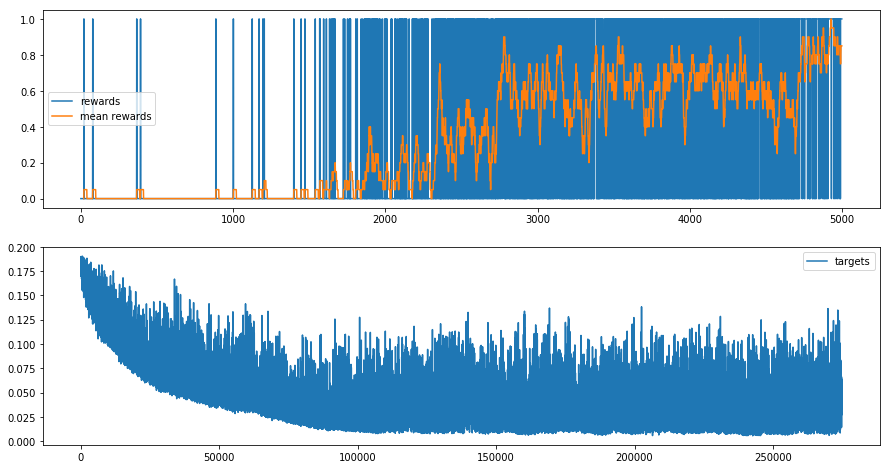

In [38]:
def train_q_learning(env, episodes: int, learning_rate: float,
                     discount: float, initial_q_value: float,
                     epsilon: float, epsilon_decay: float,
                     show_stats=True):
    
    episode_rewards = []
    targets = []
    q_values = np.full(shape=(64, 4), fill_value=initial_q_value) # Initial value used to encourage exploration
    
    for _ in prange(episodes):
        episode_reward = 0.
        
        done = False
        state = env.reset()
        while not done:
            
            # Epsilon greedy action
            if np.random.rand(1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_values[state])
            
            # Execute the action
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            
            # Bellman update
            if not done:
                target = reward + discount * np.max(q_values[next_state])
            else:
                target = reward
            q_values[state][action] += learning_rate * (target - q_values[state][action])
            targets.append(target)
            
            # Moving to next iteration
            state = next_state
        
        # Tracking success
        if episode_reward > 0:
            epsilon *= epsilon_decay
        
        episode_rewards.append(episode_reward)
        
    # Reporting
    if show_stats:
        # print(q_values)
        fig, ax = plt.subplots(figsize=(15, 8), nrows=2)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(20).mean(), label="mean rewards")
        ax[1].plot(pd.Series(targets).rolling(20).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()
        
with gym.make("FrozenLake8x8-v0") as env:   
    train_q_learning(env, episodes=5_000,
                     learning_rate=0.15, discount=0.95,
                     initial_q_value=1., # Speed up the learning at the beginning, but introduces bias
                     epsilon=0.95, epsilon_decay=0.95)